<a href="https://colab.research.google.com/github/Neelkamal18/Robotic_Perception/blob/master/UKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [349]:
#installing package
!pip install filterpy


In [0]:
#importing packages
import numpy as np
import csv
import matplotlib.pyplot as plt

#All lengths are in centimeters


In [0]:
#function defining state transition
def A_ball(x,dt,ini,netdt): # Parameters(state at kth step, time step, initial conditions, elapsed time)
  #  print(dt)
  #  print(ini)
  #  print(netdt)
   xk1 = x[0] + (x[0]-ini[0])*(dt/netdt)
   yk1 = x[1] + ini[1]*dt - 979.343*netdt*dt
   zk1 = x[2] + (x[2]-ini[2])*(dt/netdt)
  #  print(np.array([xk1,yk1,zk1]))
   return np.array([xk1,yk1,zk1])


In [0]:
#function defining output model
def h_camera(x,f=1017.036,R=3.335): # Parameters(state st kth step, Focal length, Radius)
  u = 617-(f*x[0]/x[2])
  v = 360-(f*(x[1]+(x[2]/20)-18*2.54)/x[2])
  r = f*R/x[2]
  return [u,v,r]


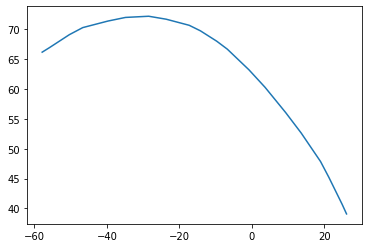

In [353]:
f=1017.036 #pixel units
R=3.335 # cms

# Reading image coordinate data from file (found by object detection)
# image x coordinates
rdx = csv.reader(open("xlist_csv.csv", "r"), delimiter=",")
x = []
for row in rdx:
  x.append(float(row[0]))
x = np.array(x)

# image y coordinates
rdy = csv.reader(open("ylist_csv.csv", "r"), delimiter=",")
y = []
for row in rdy:
  y.append(float(row[0]))
y1 = [-1*v for v in y]
y = np.array(y)

#image radius
rdr = csv.reader(open("Rlist_csv.csv", "r"), delimiter=",")
r = []
for row in rdr:
  r.append(float(row[0]))

rmean = np.mean(r)

#Calculating x,y,z in real coordinates to get initial conditions for model
zw = [f*R/rmean for ri in r]


xw = [(617-u)*R/rmean for u in x]
yw = [(360-v)*R/rmean + 18*2.54 - f*R/(rmax*20) for v in y]

# cutting off the data till the start of projectile (ball leaves hand)
init = 15
fin = len(x)-1

# measurement
zs = [[x[i],y[i],rme[i]] for i in range(init,fin)]


#Getting the timestamp of each measurement
rdfr = csv.reader(open("frame_list_csv.csv", "r"), delimiter=",")
ti = []
for row in rdfr:
  ti.append((float(row[0])/50))

#Time after start of projectile and time steps
ti_ = [t-ti[init] for t in ti[init:fin]]
dti = [ti_[i+1]-ti_[i] for i in range(len(ti_)-1)]

#initial values needed for A_ball function
ini = np.array([xw[init],(yw[init+3]-yw[init+2])/(ti[init+3]-ti[init+2]), zw[init]])

#initial states
x0 = np.array([xw[init],yw[init],zw[init]])

#plotting x,y real to understand the projectile
plt.plot(xw[init:fin],yw[init:fin])


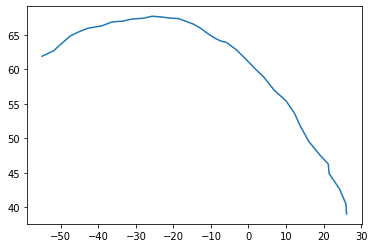

In [354]:
#importing all kalman packages
from filterpy.kalman import MerweScaledSigmaPoints #Generates sigma points
from filterpy.kalman import UnscentedKalmanFilter as UKF #Unscented Kalman Filter

#initial time step
dt = dti[0]

#generating sigma points
sigmas = MerweScaledSigmaPoints(3, alpha=.1, beta=2., kappa=0.0)

#initializing UKF
ukf = UKF(dim_x=3, dim_z=3, fx=A_ball,
          hx=h_camera, dt=dt, points=sigmas)
ukf.x = x0
ukf.R = np.diag([10, 3,1]) #Measurement covariance obtained by trial and error
ukf.Q[0,0] = 0.1
ukf.Q[1,1] = 0.1
ukf.Q[2,2] = 0.1

uxs = []
uxs.append(x0.copy())
i =0

#Running the filter through all available measurements
for z in zs[1:fin-init]:
    
    i = i+1
    ukf.predict(dti[i-1],ini=ini, netdt = ti_[i])
    ukf.update(z)
    uxs.append(ukf.x.copy())

#state values from the filter   
uxs = np.array(uxs)

#plotting x vs y given by UKF
plt.plot(uxs[:, 0],uxs[:, 1])



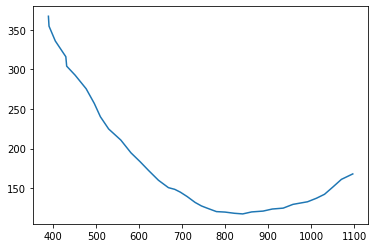

In [355]:
#Calculating x,y image coordinates for the UKF given trajectory
ur = np.array([617-(f*x/zmin) for x in uxs[:,0]])
vr = np.array([360-(f*(y+(zmin/20)-18*2.54)/zmin) for y in uxs[:,1]])

#plotting image x vs y given by UKF
plt.plot(ur,vr)

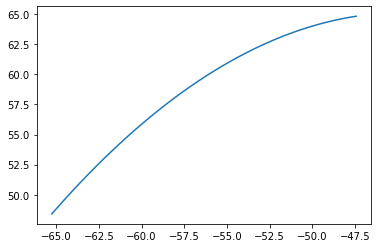

In [356]:
#Using only part of the measurements and predicting the remaining 
stop = 33
vx = (uxs[stop,0]-uxs[0,0])/ti_[stop]
vy = (uxs[stop,1]-uxs[stop-3,1])/(ti_[stop]-ti_[stop-3])
tir = np.linspace(0,0.1 + ti_[-1]+ -ti_[stop],100)
xr = np.array([uxs[stop,0] + vx*n for n in tir])
yr = np.array([uxs[stop,1] + vy*n - 0.5*979.343*(n**2) for n in tir])

#predicted trajectory x vs y real
plt.plot(xr,yr)

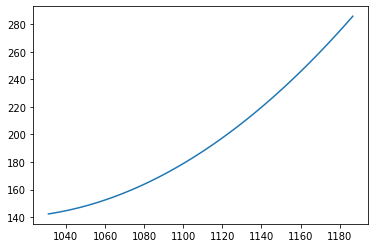

In [357]:
  #predicted x vs y in image coordinates
  urp = np.array([617-(f*x_/zmin) for x_ in xr])
  vrp = np.array([360-(f*(y_+(zmin/20)-18*2.54)/zmin) for y_ in yr])
  plt.plot(urp,vrp)

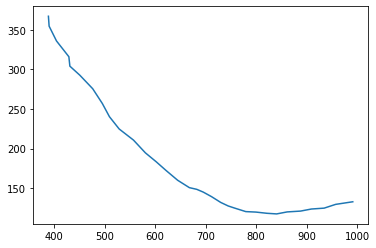

In [358]:
#UKF data till stopping
urf = ur[0:stop-1]
vrf = vr[0:stop-1]
plt.plot(urf,vrf)

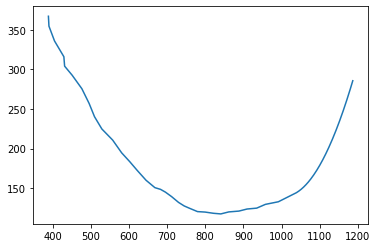

In [359]:
  # concatenated data to be shown in the video
  url = np.concatenate((urf,urp))
  vrl = np.concatenate((vrf,vrp))
  
  plt.plot(url,vrl)